# Data science Lab project

## Introduction

We start by importing the principal modules that we're going to need in order to perform the classification task. For the audio analysis part, I choose to use *Librosa* that become particulary useful when it comes to feature extraction and data visualization.

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa,librosa.display

We import the audio files (.waw) from the directory using the function *librosa.load* and we save for each record its sample rate and the actual signal. I set *sr=None* in order to preserve the original sampling rate of the input data, otherwise the signal would be automatically resample to the default sampling rate *sr=22050*.

In [2]:
path = '/Users/alessandrobonadeo/Desktop/DataScienceLab/Project/summer_2022_project/audio'
files = os.listdir(path)


samplerate = []
data = []


for f in files:
    x, y = librosa.load(os.path.join(path, f), sr = None)
    samplerate.append(x)
    data.append(y)

In order to perform classification we need to have labeled data and so we load the dataset containing the ground truth for each record. The evaluation file contains instead just the Id of the data that ar going to be used to test the performance of our final algorithm.

In [3]:
path_dev = '/Users/alessandrobonadeo/Desktop/DataScienceLab/Project/summer_2022_project'

development = pd.read_csv(os.path.join(path_dev, 'development.csv')) 
evaluation = pd.read_csv(os.path.join(path_dev, 'evaluation.csv')) 

## Datasets description

In order continue our analysis we need to understand what's in the dataset that we've just loaded. To do so we're going to look at the basic structure of our data and extract just the records that we need to train our classifier.

In [4]:
len(development)==len(data) 

False

In [5]:
len(development), len(data)

(9597, 12798)

In [6]:
len(development)+len(evaluation)

12798

As we can see from the previous snippet of code, the audio folder contain both development and evaluation file data so we need to separate these two groups to perform analysis just on the development one. In particular the development set contains 9597 records while the evaluation set 3201.

In [7]:
dev_files = [file for file in files if file in list(development['filename'])]
eval_files = [file for file in files if file in list(evaluation['filename'])]

In [8]:
len(dev_files), len(eval_files)

(9597, 3201)

Even if the audio files were ordered in the original folder, the list returned by the *os.listdir* method is in aribitary order. So to correctly labeling every input file we need to order them first.

In [9]:
values = [int(dev_files[i][:-4]) for i in range(len(dev_files))]
dct = dict(zip(dev_files,values))
dev_ordered = list(dict(sorted(dct.items(), key=lambda x: x[1])).keys())

In [10]:
values1 = [int(eval_files[i][:-4]) for i in range(len(eval_files))]
dct1 = dict(zip(eval_files,values1))
eval_ordered = list(dict(sorted(dct1.items(), key=lambda x: x[1])).keys())

In [11]:
dev_data = []
dev_samplerate = []
label = []

for i, f in enumerate(dev_ordered):
    
    x, y = librosa.load(os.path.join(path, f), sr = None)
    dev_samplerate.append(y)
    dev_data.append(x)
    label.append(development.loc[i,'emotion'])

In [12]:
eval_data = []
eval_samplerate = []

for f in eval_ordered:
    
    x, y = librosa.load(os.path.join(path, f), sr = None)
    eval_samplerate.append(y)
    eval_data.append(x)

Now we'll perform some exploratiory analysis both of the audio record and of their labels file. Let's look first at the class distribution.

In [13]:
development.groupby('emotion').count()

,filename
emotion,
Angry,1625
Disgusted,1397
Fearful,1535
Happy,1625
Neutral,1346
Sad,1625
Suprised,444


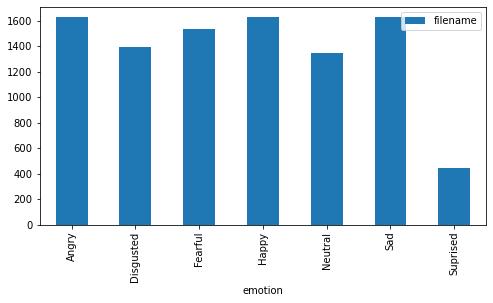

In [14]:
df = development.groupby('emotion').count().plot.bar(figsize=(8,4))

As we can see, the dataset is not perfectly balanced, the number of records vary by class and we have a very low number of istances for the class 'surprised' respect to the other ones. 

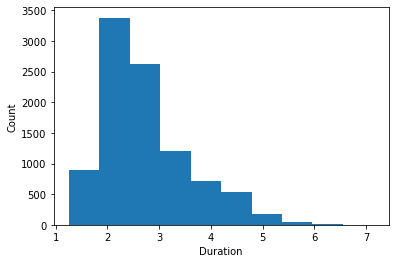

Mean = 2.726547788371366
Standard deviation = 0.8409673405257518


In [15]:
length = np.array([dev_data[i].shape[0]/dev_samplerate[i] for i in range(len(dev_data))])

plt.hist(length)
plt.xlabel('Duration')
plt.ylabel('Count')
plt.show()

mean = length.mean()
std = length.std()

print(f'Mean = {mean}')
print(f'Standard deviation = {std}')

The histogram above, instead, shows the distribution of the duration of the recording. In particular we see that the mean is about 2.73 and the distribution i fairly concentrated around this value with a standard deviation of 0.84. However, these difference in duration suggest us that we should operate some feature extraction in order to have data istances with the same numbers of attributes.

Let's look now at a particular data file, i.e. at random record and we perform on this some basic signal processing techniques that are going to be useful in the process of feature extraction. 

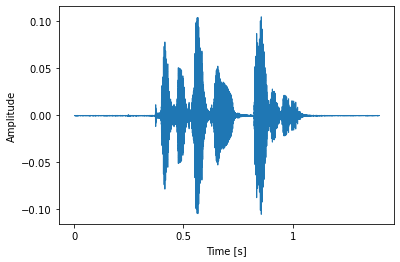

array([-3.0517578e-05, -6.1035156e-05, -6.1035156e-05, ...,
       -3.0517578e-05, -3.0517578e-05,  0.0000000e+00], dtype=float32)

In [16]:
data_example = dev_data[2]
sr_example = dev_samplerate[2]


#librosa.display.waveshow(data_example, sr = sr_example)
librosa.display.waveshow(data_example)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

data_example

The plot above represent the wave form of the signal that is its (normalized) amplitude in function of the time. Next, we want to move from the time domain (waveform) to the frequency domain and to do that we'll use FFT (Fast Fourier Trasformm).

Text(0, 0.5, 'Magnitude')

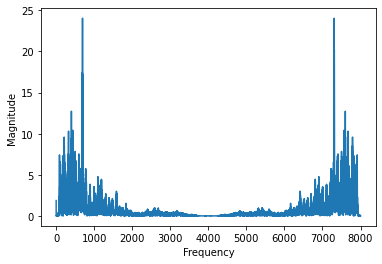

In [17]:
fft = np.fft.fft(data_example)
magnitude = np.abs(fft)
frequency = np.linspace(0, sr_example, len(magnitude))

plt.plot(frequency, magnitude)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

Since we are dealing with a real signal its fourier transform will result symmetrical and so we plot just the first half of the given array.

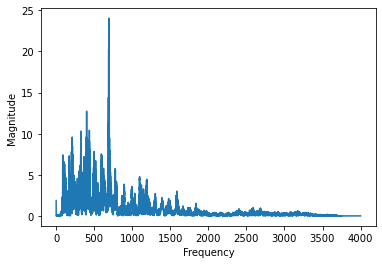

In [18]:
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(magnitude)/2)]

plt.plot(left_frequency, left_magnitude)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

We can see that most of the energy is in the low frequency. One drawback of this representation is that is satic, and that means we loose all the information about time. To overcome this problem we analyze the signal from a different point of view using the spectrogram.<br> The plot below is the spectrogram and as we can see show the magnitude af the signal for different value of both time and frequency. To compute that we use the *librosa.core.stft*: stft stands for Short Time Fourier Transform and compute the fft on short time frames in order to capture the frequency at various time istanct. The parameter *n_fft* and *hop_length* are respectively of the number of samples per frame and how much samples overlap between a frame and the following one.

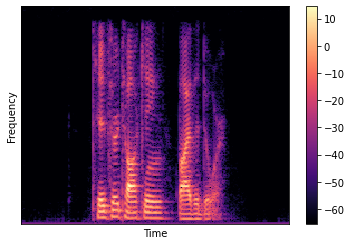

In [19]:
n_fft = 512
hop_length = 128

stft = librosa.core.stft(data_example, n_fft = n_fft, hop_length = hop_length)
spectrogram = np.abs(stft)

log_spectrogram = librosa.amplitude_to_db(spectrogram)

librosa.display.specshow(log_spectrogram, sr = sr_example, hop_length= hop_length)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.colorbar()
plt.show()

Another important feature that we can extract from an audio signal is the MFCCs (Mel Frequency Cepstral Coefficients) which model the spectral energy distribution in a perceptually meaningful way. These features are the most widely used audio features for speech emotion recognition and that's due to the fact that they capture timbral aspect of a sound aproximating the human uditory system. So the result of this feautre extaction process is a number of coefficents for each frame. Usually, for speech emotion recognition tasks, the number selected is 26.

In [20]:
MFCCs = librosa.feature.mfcc(y=data_example, n_fft = n_fft, hop_length = hop_length, n_mfcc=26)

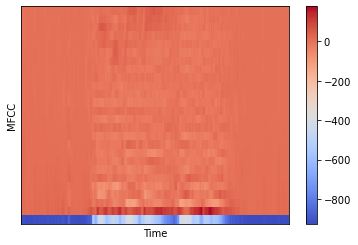

In [21]:
librosa.display.specshow(MFCCs, sr = sr_example, hop_length = hop_length)
plt.ylabel('MFCC')
plt.xlabel('Time')
plt.colorbar()
plt.show()

## Preprocessing

Before starting with the actual feature extraction process we need to apply some transfromation to data, infact as we seen above, the audio files differ in duration and so we need to find a way to represent them as feature vectors of the same length.

### Framing, hamming and short-time Fourier transform

Basically, what we do is: we split the signal in frames of the same length (*nfft* sample for each frame),  we multiply each frame by a Hamming window function and by doing so we make sure that the beginning and the end of a frame match up while smoothing the signal. After that we compute the STFT as described before. Each of these steps are applied automatically by the librosa functions that we're going to use.

In [63]:
stft_dev = []

for signal in dev_data:
    stft_dev.append(librosa.core.stft(signal, n_fft = n_fft, hop_length = hop_length))

## Feature extraction

We divide features that we're going to extract in two different groups: time domain and frequency domain features. The first ones are based on the signal itself while the second ones on the spectrum. Let's remember that for each feature the operation are computed separately on each frame.

### Time domain features

#### Energy

The energy of a signal is given by the following formula:
\begin{equation}
\sum_{t}|x(t)|^{2}
\end{equation}
where $x(t)$ is the sample at time t, and correspond to the total magnitude of the signal. In case of audio it can be seen as how loud the signal is.

In [64]:
energy_dev = []
sr = dev_samplerate[0]

for signal in dev_data:
    energy_dev.append(np.array([1/n_fft*np.sum(np.square(signal[i:i+n_fft])) 
                                     for i in range(0, len(signal), hop_length)]).reshape(1,-1))

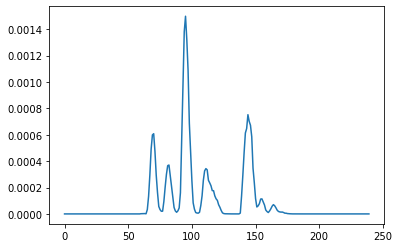

In [65]:
plt.plot(np.arange((energy_dev[2]).shape[1]), np.reshape(energy_dev[2],(240,)))
plt.show()

#### Zero Crossing rate

The zero-crossing rate (ZCR) is the rate at which a signal changes from positive to zero to negative or from negative to zero to positive. It has been widely used in both speech (emotion) recognition and music information retrieval.

In [66]:
from librosa.feature import zero_crossing_rate

zcr_dev = []

for signal in dev_data:
    zcr_dev.append(zero_crossing_rate(signal, frame_length = n_fft, hop_length = hop_length))

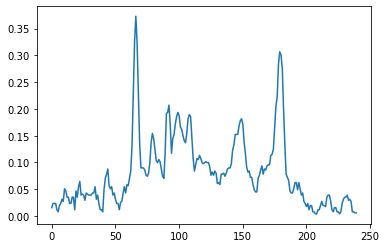

In [67]:
plt.plot(np.arange((zcr_dev[2]).shape[1]), np.reshape(zcr_dev[2],(240,)))
plt.show()

### Frequency domain features

#### Spectral centroid

The spectral centroid is a measure used to characterise a spectrum. It indicates where the center of mass of the spectrum is located. Perceptually, it has a robust connection with the impression of brightness of a sound. 

In [68]:
from librosa.feature import spectral_centroid

sc_dev = []

for signal in dev_data:
    sc_dev.append(spectral_centroid(y=signal,  sr=sr, n_fft = n_fft, hop_length = hop_length))

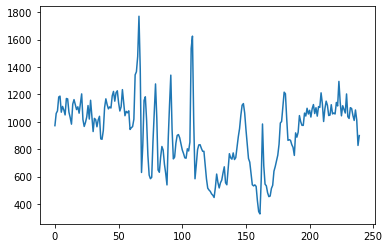

In [69]:
plt.plot(np.arange((sc_dev[2]).shape[1]), np.reshape(sc_dev[2],(240,)))
plt.show()

#### MFCCs

As we sad in the paragraph above, MFCCs are widely used in speech recognition and genre classification for their capacity of capturing timbral aspect of sounds. We decided to extract 26 mfccs that is a reasonable number for speech recognition task. 

In [70]:
mfccs_dev = []

for signal in dev_data:
    mfccs_dev.append(librosa.feature.mfcc(y=signal, sr = sr, n_fft = n_fft, hop_length = hop_length, n_mfcc=26))

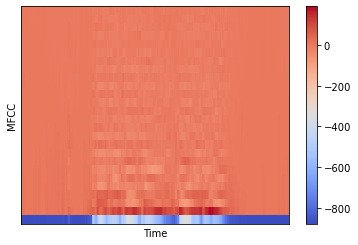

In [71]:
librosa.display.specshow(mfccs_dev[2], sr = sr_example, hop_length = hop_length)
plt.ylabel('MFCC')
plt.xlabel('Time')
plt.colorbar()
plt.show()

## Feature engineering

At this point we extracted 29 features for each audio signal (26 MFCCs and the other three). For each feature, we have vectors of different lentgh depending on the lentgh of the original audio signal, and so we compute two global statistics for each of this vector: mean and standard deviation. These two are going to be the final input of the model for a total of 58 component.

In [72]:
def compute_statistics(x):
    mean = x.mean(axis=1)
    std = x.std(axis=1)
    
    return np.concatenate((mean, std))

## Model validation

We need to compute the features matrix containing all the features previously extracted and to do so we use the function *compute_statistics* defined before.

In [116]:
X = []

for i in range(len(dev_data)):
    a = compute_statistics(energy_dev[i])
    b = compute_statistics(zcr_dev[i])
    c = compute_statistics(sc_dev[i])
    d = compute_statistics(mfccs_dev[i])
    X.append(np.concatenate((a,b,c,d)))

Before to start with the actual classification process we must apply label encoding to the target variables in order to use *scikit learn* methods. Furthermore, we apply a standar normalization to the feature matrix to avoid that variables with larger range of values have more influences than the other ones.

In [117]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
sc = preprocessing.StandardScaler()

y = le.fit_transform(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

sc.fit(X_train)
X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)

In the cell above we divided our development set in train and test set for an initial evaluation of the classification algorithm that we will use. We decide to test support vector classifier and random forest that are two of the most performing one among the traditional ones (meaning excluding deep learning) and KNN a more simple methods that we're going to consider a sort of baseline. We observe their performance without setting any particular parameter just to have a sort o baseline score for both classifier.

In [75]:
from sklearn.neighbors import KNeighborsClassifier
clf2 = KNeighborsClassifier()
clf2.fit(X_train_scaled, y_train)
y_pred = clf2.predict(X_test_scaled)
from sklearn.metrics import accuracy_score, f1_score
f1_score(y_test,y_pred, average = 'macro')

0.6038677223167631

In [115]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

from sklearn.metrics import accuracy_score, f1_score
f1_score(y_test,y_pred, average = 'macro')

0.6978593350918443

In [77]:
from sklearn.ensemble import RandomForestClassifier
clf1 =  RandomForestClassifier()
clf1.fit(X_train, y_train)
y_pred = clf1.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
f1_score(y_test,y_pred, average = 'macro')

0.6684469036896906

SVM seems to perform slightly better then random forest, while both outperform KNN. We continue our analysis we the first two. For a more accurate result we should test both methods using different parameters. To find the optimals one we use K-fold cross validation so we limit overfitting over the test data.

In [78]:
from sklearn.model_selection import ParameterGrid

paramsSV = {
    "kernel": ['rbf', 'sigmoid'],
    "C": [1, 5, 10, 50, 100, 500, 1000]
}


paramsRF = {
    "max_depth": [None, 10, 50, 100],
    "n_estimators": [100, 250, 500]
}

In [79]:
from sklearn.model_selection import KFold

y = le.fit_transform(label)
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, stratify=y)
kf = KFold(5)


f1_SVM = []
for config in ParameterGrid(paramsSV):
    clf_f1 = []
    counts = []
    for train_indices, valid_indices in kf.split(X_train_valid):
        X_train = np.array(X_train_valid)[train_indices]
        y_train = np.array(y_train_valid)[train_indices]
        X_valid = np.array(X_train_valid)[valid_indices]
        y_valid = np.array(y_train_valid)[valid_indices]
        
        # keep track of the number of elements in each split
        counts.append(len(train_indices)) 
        
        X_train_scaled = sc.fit_transform(X_train)
        X_valid_scaled = sc.transform(X_valid)
        clf = SVC(**config)
        clf.fit(X_train_scaled, y_train)
        f1 = f1_score(y_valid, clf.predict(X_valid_scaled), average = 'macro')
        clf_f1.append(f1)
    f1_SVM.append(np.average(clf_f1, weights=counts))

In [80]:
max(f1_SVM)

0.7081053263870793

In [81]:
best_configSVM = list(ParameterGrid(paramsSV))[np.argmax(f1_SVM)]

X_train_valid_scaled = sc.fit_transform(X_train_valid)
X_test_scaled = sc.transform(X_test)

clf = SVC(**best_configSVM)
clf.fit(X_train_valid_scaled, y_train_valid)
f1_score(y_test, clf.predict(X_test_scaled), average = 'macro')

0.7141800110896181

In [82]:
best_configSVM

{'C': 10, 'kernel': 'rbf'}

In [83]:
from sklearn.model_selection import KFold

y = le.fit_transform(label)
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, stratify=y)
kf = KFold(5)


f1_RF = []
for config in ParameterGrid(paramsRF):
    clf_f1 = []
    counts = []
    for train_indices, valid_indices in kf.split(X_train_valid):
        X_train = np.array(X_train_valid)[train_indices]
        y_train = np.array(y_train_valid)[train_indices]
        X_valid = np.array(X_train_valid)[valid_indices]
        y_valid = np.array(y_train_valid)[valid_indices]
        
        # keep track of the number of elements in each split
        counts.append(len(train_indices)) 
        
        clf1 = RandomForestClassifier(**config)
        clf1.fit(X_train, y_train)
        f1 = f1_score(y_valid, clf1.predict(X_valid), average = 'macro')
        clf_f1.append(f1)
    f1_RF.append(np.average(clf_f1, weights=counts))

KeyboardInterrupt: 

In [ ]:
max(f1_RF)

In [ ]:
best_configRF = list(ParameterGrid(paramsRF))[np.argmax(f1_RF)]

X_train_valid_scaled = sc.fit_transform(X_train_valid)
X_test_scaled = sc.transform(X_test)

clf = RandomForestClassifier(**best_configRF)
clf.fit(X_train_valid_scaled, y_train_valid)
f1_score(y_test, clf.predict(X_test_scaled),average ='macro')

In [ ]:
best_configRF

We observe that SVM has performed a bit better then random forest so we are going to use it fo our final task.  

In [ ]:
np.array(list(ParameterGrid(paramsSV)))[np.argsort(f1_SVM)]

As we can see the top performing parameter configuration contain *'kernel':'rbf'* (radial basis function kernel), so we decide to fix it and explore a bit more in depth the parameter *C* discretizing more its value space.

In [105]:
paramsSV = {
    "C": [5, 6, 7, 8, 9, 10, 11 ,12, 13, 14, 15]
}

In [85]:
from sklearn.model_selection import KFold

y = le.fit_transform(label)
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, stratify=y)
kf = KFold(5)


f1_SVM = []
for config in ParameterGrid(paramsSV):
    clf_f1 = []
    counts = []
    for train_indices, valid_indices in kf.split(X_train_valid):
        X_train = np.array(X_train_valid)[train_indices]
        y_train = np.array(y_train_valid)[train_indices]
        X_valid = np.array(X_train_valid)[valid_indices]
        y_valid = np.array(y_train_valid)[valid_indices]
        
        # keep track of the number of elements in each split
        counts.append(len(train_indices)) 
        
        X_train_scaled = sc.fit_transform(X_train)
        X_valid_scaled = sc.transform(X_valid)
        clf = SVC(**config)
        clf.fit(X_train_scaled, y_train)
        f1 = f1_score(y_valid, clf.predict(X_valid_scaled), average = 'macro')
        clf_f1.append(f1)
    f1_SVM.append(np.average(clf_f1, weights=counts))

In [119]:
best_configSVM = list(ParameterGrid(paramsSV))[np.argmax(f1_SVM)]

X_train_valid_scaled = sc.fit_transform(X_train_valid)
X_test_scaled = sc.transform(X_test)

clf = SVC(**best_configSVM)
clf.fit(X_train_valid_scaled, y_train_valid)
f1_score(y_test, clf.predict(X_test_scaled), average = 'macro')

0.7097378906001467

In [110]:
best_configSVM

{'C': 12}

Text(0, 0.5, 'f1-score')

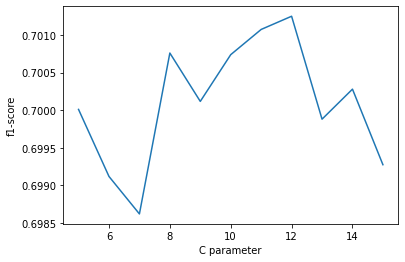

In [111]:
plt.plot(paramsSV['C'], f1_SVM)
plt.xlabel('C parameter')
plt.ylabel('f1-score')

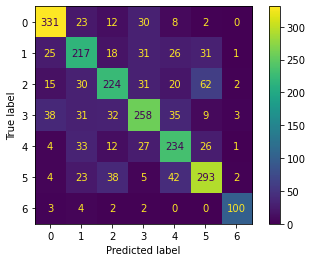

In [120]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, clf.predict(X_test_scaled), labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [121]:
le.inverse_transform(clf.classes_)

array(['Angry', 'Disgusted', 'Fearful', 'Happy', 'Neutral', 'Sad',
       'Suprised'], dtype='<U9')

## Classification and submission

After selecting the best model, based on the results above, we proceed with the final task of this project: classify the evaluation dataset and creating the the csv file that will be used for the result.

In [90]:
def extract_features(data):
    
    #energy
    energy_dev = []
    sr = dev_samplerate[0]
    for signal in data:
        energy_dev.append(np.array([1/n_fft*np.sum(np.square(signal[i:i+n_fft])) 
                                    for i in range(0, len(signal), hop_length)]).reshape(1,-1))
    #zero crossing rate
    zcr_dev = []
    for signal in data:
        zcr_dev.append(zero_crossing_rate(signal, frame_length = n_fft, hop_length = hop_length))
    
    #spectral centroid
    sc_dev = []
    for signal in data:
        sc_dev.append(spectral_centroid(y=signal,  sr=sr, n_fft = n_fft, hop_length = hop_length))
    
        
    #mfccs
    mfccs_dev = []
    for signal in data:
        mfccs_dev.append(librosa.feature.mfcc(y=signal, sr = sr, n_fft = n_fft, 
                                              hop_length = hop_length, n_mfcc=26))
        
    return energy_dev, zcr_dev, sc_dev, mfccs_dev

We have defined this function in order to make the code readable in the process of extracting feature from development and evaluation dataset. The final model will then be trained on the complete development dataset, so we need to recompute the two different features matrix.

In [91]:
energy_test, zcr_test, sc_test, mfccs_test = extract_features(eval_data)

In [92]:
energy_train, zcr_train, sc_train, mfccs_train = extract_features(dev_data)

In [93]:
X_train = []

for i in range(len(dev_data)):
    a = compute_statistics(energy_train[i])
    b = compute_statistics(zcr_train[i])
    c = compute_statistics(sc_train[i])
    d = compute_statistics(mfccs_train[i])
    X_train.append(np.concatenate((a,b,c,d)))

In [94]:
X_test = []

for i in range(len(eval_data)):
    a = compute_statistics(energy_test[i])
    b = compute_statistics(zcr_test[i])
    c = compute_statistics(sc_test[i])
    d = compute_statistics(mfccs_test[i])
    X_test.append(np.concatenate((a,b,c,d)))

In [95]:
y_train = le.fit_transform(label)


sc1 = preprocessing.StandardScaler()
sc1.fit(X_train)
X_train_scaled = sc1.transform(X_train)
X_test_scaled = sc1.transform(X_test)

clf_ev = SVC(C = 12, kernel = 'rbf')
clf_ev.fit(X_train_scaled, y_train)


y_pred = clf_ev.predict(X_test_scaled)

In [96]:
y_pred_final = le.inverse_transform(y_pred)

In [97]:
x1 = pd.Series(eval_ordered)
x2 = pd.Series(y_pred_final)

In [98]:
file_df = pd.DataFrame({'Id':x1, 'Predicted':x2})

In [99]:
file_df.to_csv(os.path.join(path_dev, 'submission.csv'), index = False)

We created a *pandas* DataFrame to save the results on the test set and we use the *to_csv* methods to save the data obtained in a csv file in our pc.